![alt text](DataKind_orange.png)

### Multiclass Classifier for contract clause types

In [1]:
import os, io, requests
from collections import Counter
from itertools import product
import re
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk import word_tokenize, pos_tag
from textblob import TextBlob
from textstat.textstat import textstat
from langdetect import detect

from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('notebook', rc={'figure.figsize': (10, 6)}, font_scale=1.5)

In [2]:
resource_folder = 'contract_data/Contracts_Annotations/resource_contracts/'
land_folder = 'contract_data/Contracts_Annotations/openland_contracts/'
folders = [resource_folder,land_folder]

In [3]:
labels = ['stabilization','royalties']
n_folds = 3

In [4]:
# Languages must be supported by NLTK Snowball Stemmer and stopwords
languages = ['english','french','spanish','italian','portuguese','dutch','swedish']
s = requests.get('http://data.okfn.org/data/core/language-codes/r/language-codes.csv').content
language_codes = pd.read_csv(io.StringIO(s.decode('utf-8')))
language_codes.columns = ['language_code','Language']

In [5]:
model = OneVsRestClassifier(RandomForestClassifier(
                                                    n_estimators=500,
                                                    max_features=.33, 
                                                    max_depth=10, 
                                                    n_jobs=-1, 
                                                    oob_score=True))

In [6]:
annotations = pd.DataFrame()
for folder in folders:
    xls_files = [f for f in os.listdir(folder) if f.lower().endswith('.xls')]
    for xls in xls_files:
        temp = pd.read_excel(folder + xls)
        if len(temp) > 0:
            temp['OCID'] = xls[:-4]
            temp['Source'] = folder.split('/')[-2]
            annotations = annotations.append(temp)
print "Number of annotations: " + str(len(annotations))

Number of annotations: 20609


In [7]:
labels = [label.lower() for label in labels]
y = [x.lower() if x.lower() in labels else 'other' for x in annotations['Category']]
yunique = list(np.unique(y))
for item in yunique:
    print str("{0:.2f}%".format(100*y.count(item) / float(len(y)))) + " " + item

96.08% other
2.37% royalties
1.54% stabilization


In [8]:
annotations.head(2)

,Category,Topic,Annotation Text,PDF Page Number,Article Reference,OCID,Source
0,Project title,General,Production Sharing Contract between Sociedade ...,1,Preamble,ocds-591adf-0014595575,resource_contracts
1,"Name of field, block, deposit or site",General,Block 20/11,1,Preamble,ocds-591adf-0014595575,resource_contracts


In [9]:
punctuation_re = r'[^\w\s#]'

def punctuation_remove(text):
    """
    Mutates and returns text where all punctuation besides hashtags,
    are replaced
    """
    new_text = nltk.regexp.re.sub(punctuation_re, ' ', text)
    return new_text

def perform_lowercase(text):
    """
    Mutates and returns text where all characters are lowercased
    """
    try:
        new_text = text.lower()
    except:
        new_text = str(text).lower()
    return new_text

def doublespace_remove(text):
    return re.sub(' +',' ',text)

def textblobsent(text):
    '''
    returns the TextBlob polarity and subjectivity
    '''
    text = text.encode('ascii','ignore')
    sent = TextBlob(text).sentiment
    return pd.Series([sent.polarity,sent.subjectivity])

def get_length(document):
    return len(document)

def get_num_words(document):
    return len(document.split())

def get_avg_wordlength(document):
    wordlengths = [len(word) for word in document.split()]
    if len(wordlengths) == 0:
        return 0
    else:
        return np.mean(wordlengths)

def get_num_syllables(text):
    '''
    returns the number of syllables
    '''
    return textstat.syllable_count(text)

def determine_tense(essay):
    '''
    Returns the number of past, present and future tense verbs in a given text
    '''
    text = word_tokenize(essay)
    tagged = pos_tag(text)

    numfuture = len([word for word in tagged if word[1] == "MD"])
    numpresent = len([word for word in tagged if word[1] in ["VBP", "VBZ","VBG"]])
    numpast = len([word for word in tagged if word[1] in ["VBD", "VBN"]]) 
    
    return pd.Series([numpast,numpresent,numfuture],index=['NumPast','NumPresent','NumFuture'])

def get_pos_tags(text):
    '''
    Returns part of speech tag counts
    '''
    text = word_tokenize(text)
    tagged = pos_tag(text)

    counts = Counter([word[1] for word in tagged]).items()
    countdict = {}
    for key, value in counts:
        countdict[key] = value  
    
    return countdict

def detect_lang(text):
    '''
    Returns detected language
    '''
    text = doublespace_remove(text)
    try:
        return detect(text)
    except:
        return 'None'
    
def remove_stopwords(row):
    '''
    Multilingual stopwords removal
    '''
    language = row['Language']
    if language in languages:
        text = ' '.join([word for word in row['CleanText'].split(' ') if word not in stopwords.words(language)])
        return text
    else:
        return row['CleanText']
    
def stem_words(row):
    ''' 
    Multilingual word stemmer
    '''
    language = row['Language']    
    if language in languages:
        stemmer = SnowballStemmer(language)
        text = ' '.join([stemmer.stem(word) for word in row['CleanText_NoStop'].split(' ')])
        return text
    else:
        return row['CleanText_NoStop']

In [10]:
def clean_text(df):
    df['Annotation Text'].fillna('',inplace=True)
    df['CleanText'] = df['Annotation Text']
    func_list = [perform_lowercase,punctuation_remove,doublespace_remove]
    for func in func_list:
        df['CleanText'] = df['CleanText'].apply(func)

    return df

def featurize(df):
    
    df['NumWords'] = df['CleanText'].apply(get_num_words)
    df['NumCharacters'] = df['CleanText'].apply(get_length)
    df['AvgWordLength'] = df['CleanText'].apply(get_avg_wordlength)
    df['NumSyllables'] = df['CleanText'].apply(get_num_syllables)
    df['language_code'] = df['CleanText'].apply(detect_lang)
    df = df.merge(language_codes,how='left',on='language_code')
    df['Language'] = df['Language'].astype('str')
    df['Language'] = df['Language'].apply(lambda x: x.lower().split(';')[0])
    df['Language'] = df['Language'].apply(lambda x: x if x in languages else 'other')
    df['Language'].fillna('None')
    langdummies = pd.get_dummies(df['Language'],prefix='language')
    
    df['CleanText_NoStop'] = df.apply(remove_stopwords,axis=1)
    df['CleanText_NoStop_Stemmed'] = df.apply(stem_words,axis=1)
    df.drop(['language_code','Language'],axis=1,inplace=True)
    
    tenses = df['CleanText'].apply(determine_tense)
    tenses.columns = ['tense_' + col for col in tenses.columns]
    
    postagcounts = []
    for index, row in df.iterrows():
        postagcounts.append(get_pos_tags(row['CleanText']))    
    postagdf = pd.DataFrame(postagcounts).fillna(0)
    postagdf.index = df.index
    postagdf.columns = ['postag_' + col for col in postagdf.columns]
    
    textblobsentdf = df['CleanText'].apply(textblobsent)
    textblobsentdf.columns = ['TextblobPolarity','TextblobSubjectivity']
    df = pd.concat([df,textblobsentdf,tenses,postagdf,langdummies],axis=1)
    
    return df

In [11]:
annotations = clean_text(annotations)
annotations = featurize(annotations)

In [12]:
tfidf_vectorizer = TfidfVectorizer(max_df= .6,
                                 min_df= .002, 
                                 stop_words=None,  
                                 use_idf=True, 
                                 ngram_range=(1,4))
tfidf_matrix = tfidf_vectorizer.fit_transform(annotations['CleanText_NoStop_Stemmed'].values.astype('U'))
terms = tfidf_vectorizer.get_feature_names()
tfidf_matrix = tfidf_matrix.todense()
tfidf = pd.DataFrame(tfidf_matrix)
tfidf.index = annotations.index
tfidf.columns = terms
print tfidf.shape

(20609, 12469)


In [13]:
exclude = ['Source','Category','Topic','Annotation Text','CleanText','CleanText_NoStop','CleanText_NoStop_Stemmed',
           'OCID','PDF Page Number','Article Reference','MD','VBP','VBZ','VBG','VBD','VBN','other',"''"]
features = [col for col in annotations.columns.tolist() if not col in exclude]

In [14]:
X = pd.concat([tfidf,annotations[features]],axis=1)

In [15]:
X.fillna(0,inplace=True)
X = X.rename(columns = {'fit':'fit_feature'})

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [17]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [18]:
print str(n_folds) + ' Fold CV Score: ' + str(np.mean(cross_val_score(model, X, y, cv=n_folds)))
model.fit(X_train, y_train)
test_pred = model.predict(X_test)

3 Fold CV Score: 0.98243456651


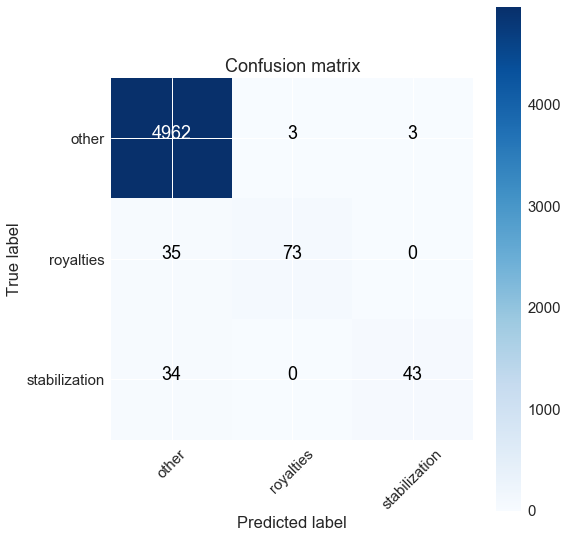

In [19]:
cnf_matrix = confusion_matrix(y_test, test_pred)
np.set_printoptions(precision=2)

# Plot confusion matrix
sns.set_context(rc={"figure.figsize": (8, 8)})       
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=model.classes_,
                          title='Confusion matrix')

In [20]:
def get_feature_importances(clf,X):
    '''
    returns feature importances
    '''
    classes = clf.classes_
    feat_importance = {}
    for i in range(len(classes)):
        importances = clf.estimators_[i].feature_importances_
        indices = np.argsort(importances)[::-1]
        feat_importance[classes[i]] = pd.DataFrame(X.columns, importances)    
        feat_importance[classes[i]].reset_index(inplace=True)
        feat_importance[classes[i]].columns = ['Importance','Feature']
        feat_importance[classes[i]].sort_values(by='Importance', axis=0, ascending=True, inplace=True)
        feat_importance[classes[i]].set_index('Feature',inplace=True)
    return feat_importance

In [45]:
for i in model.classes_:
    print i

other
royalties
stabilization


Top 15 Features for royalties


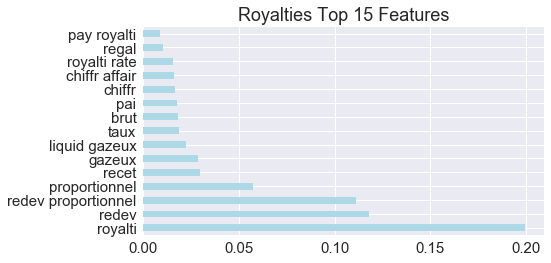

Top 15 Features for stabilization


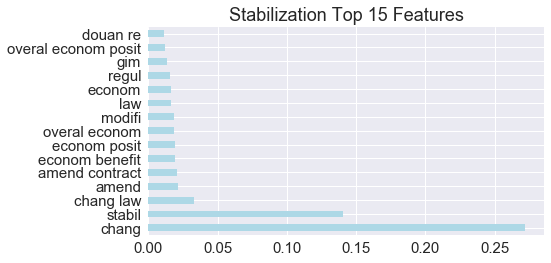

In [52]:
n = 15
sns.set_context(rc={"figure.figsize": (8, 4)})       
importances = {}
importances = get_feature_importances(model,X)
for i in model.classes_[1:]:
    print 'Top ' + str(n) + ' Features for ' + i
    importances[i].index.name=None 
    importances[i].sort_values(by='Importance',ascending=False).head(n).plot(kind='barh',title=i.title() + ' Top ' + str(n) + ' Features',legend=False, color='lightblue')
    plt.tight_layout()
    plt.show()

In [22]:
annotations['Actual'] = y
annotations['Predicted'] = model.predict(X)

In [25]:
missed = len(annotations[annotations['Predicted'] != annotations['Actual']])
hit = len(annotations) - missed
print 'Hit: ' + str(hit)
print 'Missed: ' + str(missed)
print 'Accuracy: ' + str(round(hit / float(len(annotations)),3))

Hit: 20392
Missed: 217
Accuracy: 0.989


In [27]:
false_positives = annotations[(annotations['Predicted'] != annotations['Actual']) 
                              & (annotations['Predicted'] != 'other')]
false_negatives = annotations[(annotations['Predicted'] != annotations['Actual']) 
                              & (annotations['Predicted'] == 'other')]
true_positives = annotations[(annotations['Predicted'] == annotations['Actual']) 
                              & (annotations['Predicted'] != 'other')]
print 'False Positives: ' + str(len(false_positives))
print 'False Negatives: ' + str(len(false_negatives))

False Positives: 7
False Negatives: 210


In [28]:
false_positives[['OCID','Category','Predicted','CleanText']].to_csv('classification_results/False_Positives.csv')

In [30]:
false_negatives[false_negatives['language_english'] == 1][['OCID','Category','Predicted','CleanText']].to_csv('classification_results/False_Negatives.csv')